In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from aging.behavior.syllables import relabel_by_usage
from aging.plotting import figure, legend, format_plots
import colorcet as cc

In [2]:
format_plots()

In [3]:
def get_ont_map():
    df = pd.read_parquet(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_08/ontogeny_males_syllable_df_v00.parquet"
    )
    _, umap = relabel_by_usage(df, return_map=True)
    return umap

In [4]:
def get_session_and_experiment_type(df):
    session_type = []
    exp_type = []
    for idx, row in df.iterrows():
        masks = df.loc[df['subject_name'] == row.subject_name]
        masks.drop(index=idx)
        if masks['date'].iloc[0] < row.date:
            session_type.append('after')
        else:
            session_type.append('before')
        if int(row.subject_name.split('_')[1]) in [2, 4]:
            exp_type.append('klothos')
        else:
            exp_type.append('saline')
    df['session_type'] = session_type
    df['exp_type'] = exp_type
    return df

In [5]:
def load_klotho():
    umap = get_ont_map()
    df = pd.read_parquet(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_08/klothos_syllable_df_v00.parquet"
    )
    df["relabeled_syllables"] = df["syllables"].map(umap)
    usages = (
        df.query("onsets")
        .groupby(["subject_name", "date"])["relabeled_syllables"]
        .value_counts(normalize=True)
    )
    usage_mtx = pd.pivot_table(
        usages.reset_index(),
        index=["subject_name", "date"],
        columns="relabeled_syllables",
        values="proportion",
        fill_value=0,
    )
    exp_mapping = get_session_and_experiment_type(usage_mtx[0].reset_index())
    exp_mapping = exp_mapping.set_index(usage_mtx.index.names)
    usage_mtx[['exp_type', 'session_type']] = exp_mapping[['exp_type', 'session_type']]
    usage_mtx.set_index(['exp_type', 'session_type'], append=True, inplace=True)
    return usage_mtx

In [6]:
def get_mouse_size():
    df = pd.read_parquet(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_08/klothos_syllable_df_v00.parquet"
    )
    sizes = df.groupby(['subject_name', 'date'])[['area_px', 'recon_area']].median()
    return sizes


In [7]:
klotho_mtx = load_klotho()

In [8]:
ont_usage_mtx = pd.read_parquet("/n/groups/datta/win/longtogeny/data/ontogeny/version_08/ontogeny_males_clean_v2.parquet")

In [9]:
mouse_sizes = get_mouse_size()

In [10]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [11]:
pipeline = make_pipeline(StandardScaler(), PLSRegression(n_components=2))

In [12]:
pipeline.fit(ont_usage_mtx, ont_usage_mtx.index.get_level_values('age'))

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('plsregression', PLSRegression())])

In [13]:
klotho_age = pipeline.predict(klotho_mtx.reindex(columns=ont_usage_mtx.columns, fill_value=0))

In [14]:
#klotho_age = pd.Series(klotho_age, index=klotho_mtx.index, name="pred_age").droplevel(level=['exp_type', 'session_type'])

In [15]:
mouse_sizes['pred_age'] = klotho_age

In [16]:
mouse_sizes['weight'] = [38.6
                         ,38.6
                         ,31.2
                         ,31.2
                         ,32.5
                         ,32.5
                         ,38.1
                         ,38.1
                         ,27.4
                         ,27.4
                         ,38.2
                         ,38.2
                         ,35.6
                         ,35.6
                         ,32.1
                         ,32.1
                         ,41.9
                         ,41.9
                         ,39.7
                         ,39.7
                         ,38.5
                         ,38.5
                         ,37.6
                         ,37.6
                         ,40.4
                         ,40.4
                         ,35.4
                         ,35.4
                         ,48.8
                         ,48.8
                         ,38.3
                         ,38.3]

In [17]:
mouse_sizes

area_px  recon_area   pred_age  weight
subject_name date                                                       
K90M_01_01   2023-12-05 15:33:09    670.0       606.0  52.129202    38.6
             2023-12-06 15:26:40    696.0       608.0  57.968006    38.6
K90M_01_02   2023-12-05 12:33:28    596.0       597.0  47.401731    31.2
             2023-12-06 12:28:27    590.0       587.0  31.911530    31.2
K90M_01_03   2023-12-05 15:33:42    591.0       582.0  49.289978    32.5
             2023-12-06 15:30:14    605.0       577.0  49.662968    32.5
K90M_01_04   2023-12-05 12:33:57    664.0       593.0  46.913744    38.1
             2023-12-06 12:30:26    676.0       597.0  42.459029    38.1
K90M_02_01   2023-12-05 16:10:55    634.0       543.0  48.080408    27.4
             2023-12-06 16:17:22    644.0       540.0  41.654340    27.4
K90M_02_02   2023-12-05 13:11:06    657.0       589.0  52.541565    38.2
             2023-12-06 13:17:36    636.0       587.0  46.506471    38.2
K90M_02_03   2023-12-05 16:11:24    622.0       560.0  44.758230    35.6
             2023-12-06 16:17:53    626.0       573.0  46.441441    35.6
K90M_02_04   2023-12-05 13:11:35    593.0       585.0  47.623601    32.1
             2023-12-06 13:18:03    546.0       563.0  37.179765    32.1
K90M_03_01   2023-12-05 16:47:29    749.0       569.0  54.901525    41.9
             2023-12-06 16:54:06    729.0       578.0  59.909732    41.9
K90M_03_02   2023-12-05 13:47:43    698.0       587.0  58.349853    39.7
             2023-12-06 13:54:19    672.0       594.0  60.743601    39.7
K90M_03_03   2023-12-05 16:48:00    671.0       593.0  52.811498    38.5
             2023-12-06 16:54:35    668.0       585.0  52.695861    38.5
K90M_03_04   2023-12-05 13:48:12    650.0       584.0  47.531518    37.6
             2023-12-06 13:54:47    657.0       584.0  49.842523    37.6
K90M_04_01   2023-12-05 17:24:35    714.0       618.0  62.474371    40.4
             2023-12-06 17:29:57    724.0       613.0  66.185011    40.4
K90M_04_02   2023-12-05 14:24:46    654.0       561.0  59.895146    35.4
             2023-12-06 14:30:09    645.0       563.0  58.165604    35.4
K90M_04_03   2023-12-05 17:25:04    756.0       577.0  56.461363    48.8
             2023-12-06 17:30:26    758.0       561.0  52.930425    48.8
K90M_04_04   2023-12-05 14:25:18    666.0       595.0  67.796067    38.3
             2023-12-06 14:30:35    668.0       589.0  66.020570    38.3

Text(0.5, 1.0, 'pearson')

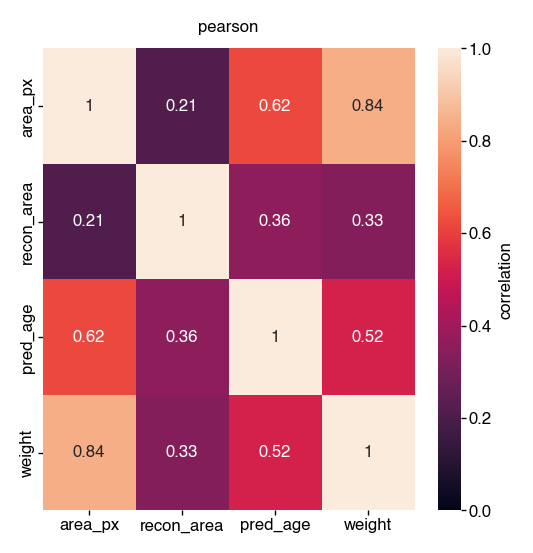

In [18]:
sns.heatmap(mouse_sizes.corr(method='pearson'), annot=True, cbar_kws={'label': "correlation"}, vmin=0, )
plt.title('pearson')

Text(0.5, 1.0, 'spearman')

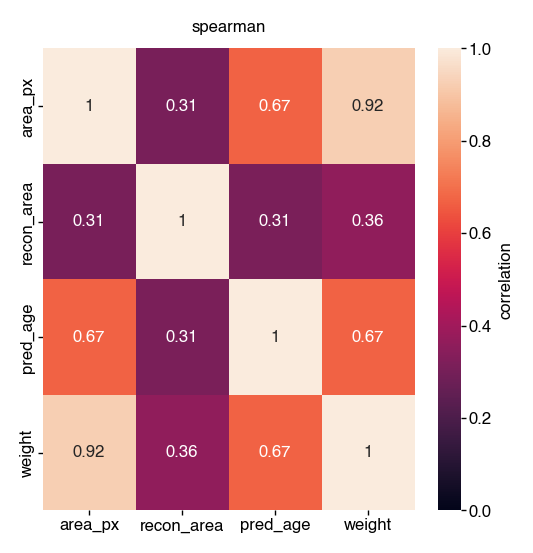

In [19]:
sns.heatmap(mouse_sizes.corr(method='spearman'), annot=True, cbar_kws={'label': "correlation"}, vmin=0, )
plt.title('spearman')

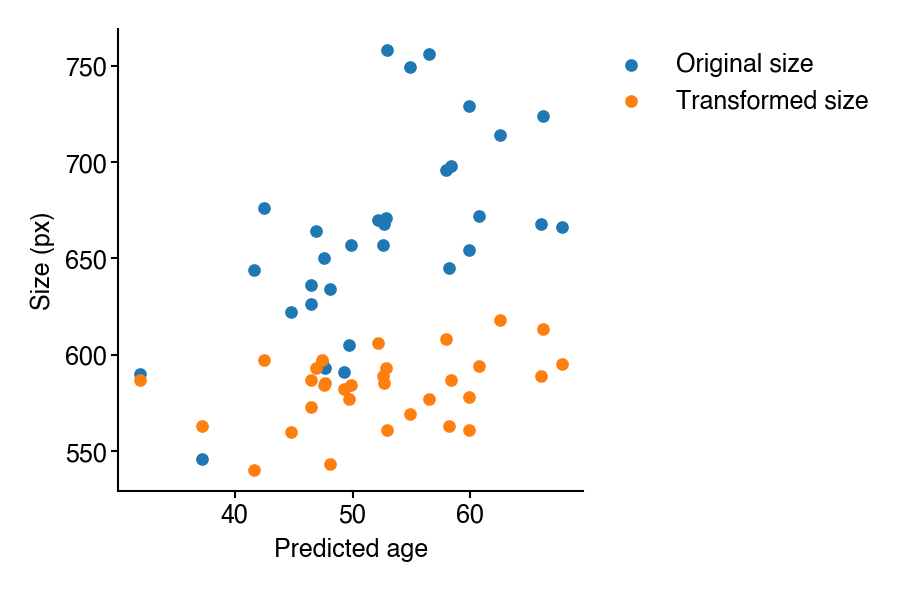

In [20]:
fig = figure(2, 2)
ax = fig.gca()
ax.scatter(mouse_sizes['pred_age'], mouse_sizes['area_px'], s=5, label="Original size")
ax.scatter(mouse_sizes['pred_age'], mouse_sizes['recon_area'], s=5, label="Transformed size")
ax.set(xlabel="Predicted age", ylabel="Size (px)")
legend()
sns.despine()

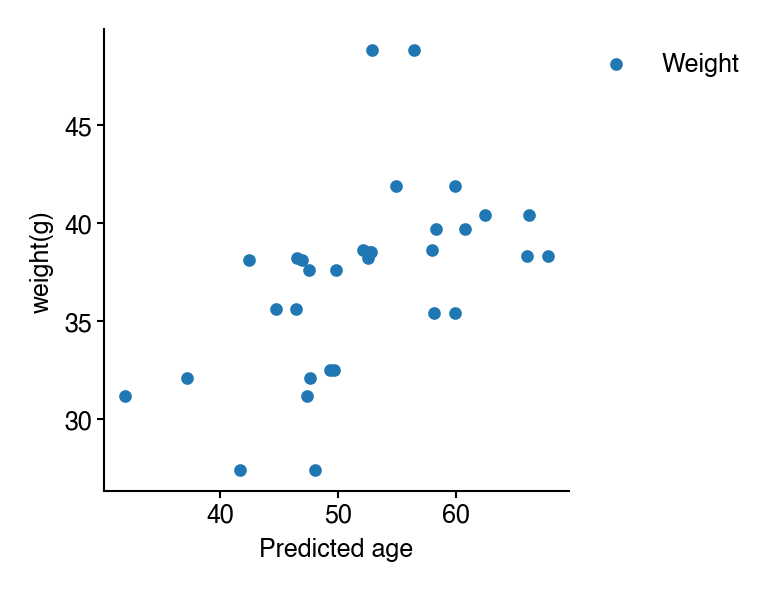

In [21]:
fig = figure(2, 2)
ax = fig.gca()
ax.scatter(mouse_sizes['pred_age'], mouse_sizes['weight'], s=5, label="Weight")
ax.set(xlabel="Predicted age", ylabel="weight(g)")
legend()
sns.despine()